## Vehicle Detection Project

### Write a software pipeline to identify vehicles in a video from a front-facing camera on a car.

(1) Extract HOG features from the training images and settle on choice of HOG parameters.  
(2) Train a classifier using the selected HOG features (and color features if used).  
(3) Implement a sliding window search, deciding the scales to search and how much to overlap windows.  
(4) Show some examples of test images to demonstrate the pipeline works.  
(5) Implement some kind of filter for false positives and some method for combining overlapping bounding boxes.

In [1]:
import cv2
import glob
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

vehicles\GTI_Far\image0000.png
non-vehicles\Extras\extra1.png


The number of vehicle images: 8792
The number of non-vehicle images: 8968


The shape of vehicle images: (64, 64, 3)
The shape of non-vehicle images: (64, 64, 3)


The shape of the overall images: (17760, 64, 64, 3)
The shape of the overall labels: (17760,)




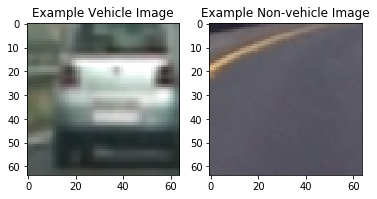

In [2]:
# Put project image folder vehicles and non-vehicles under the root of the project folder
# Get all vehicle and non-vehicle images' paths
vehicle_imgs = glob.glob('vehicles/*/*.png')
non_vehicle_imgs = glob.glob('non-vehicles/*/*.png')

vehicle_num = len(vehicle_imgs)
non_vehicle_num = len(non_vehicle_imgs)

print(vehicle_imgs[0])
print(non_vehicle_imgs[0])
print("\n")

print("The number of vehicle images: " + str(vehicle_num))
print("The number of non-vehicle images: " + str(non_vehicle_num))
print("\n")

vehicle_ex = cv2.imread(vehicle_imgs[100])
vehicle_ex = cv2.cvtColor(vehicle_ex, cv2.COLOR_BGR2RGB)
vehicle_ex_shape = vehicle_ex.shape

non_vehicle_ex = cv2.imread(non_vehicle_imgs[100])
non_vehicle_ex = cv2.cvtColor(non_vehicle_ex, cv2.COLOR_BGR2RGB)
non_vehicle_ex_shape = non_vehicle_ex.shape

fig = plt.figure(1)
plt.subplot(121)
plt.imshow(vehicle_ex)
plt.title('Example Vehicle Image')
plt.subplot(122)
plt.imshow(non_vehicle_ex)
plt.title('Example Non-vehicle Image')

print("The shape of vehicle images: " + str(vehicle_ex_shape))
print("The shape of non-vehicle images: " + str(non_vehicle_ex_shape))
print("\n")

# Prepare training data
vehicle_images = []
for img in vehicle_imgs:
    img_bgr = cv2.imread(img)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    vehicle_images.append(img_rgb)
#vehicle_images = np.array(vehicle_images)  
    
non_vehicle_images = []
for img in non_vehicle_imgs:
    img_bgr = cv2.imread(img)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    non_vehicle_images.append(img_rgb)
#non_vehicle_images = np.array(non_vehicle_images)

vehicle_labels = np.ones(len(vehicle_images))
non_vehicle_labels = np.zeros(len(non_vehicle_images))

overall_images = np.concatenate((vehicle_images, non_vehicle_images))
overall_labels = np.concatenate((vehicle_labels, non_vehicle_labels))

print("The shape of the overall images: " + str(overall_images.shape))
print("The shape of the overall labels: " + str(overall_labels.shape))
print("\n")

### HOG Features Extraction

C:\Users\hang\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


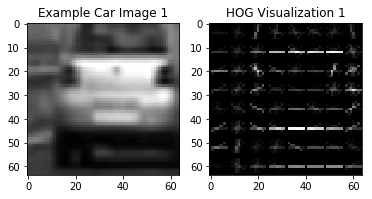

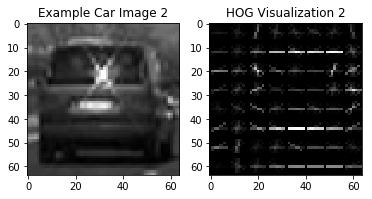

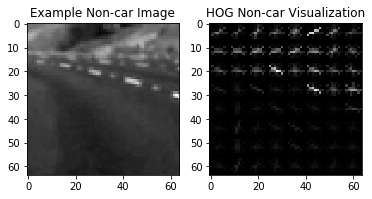

In [3]:
"""
Code reference: Lesson 23 Object Detection: scikit-image HOG

"""
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
# Plot the examples

vehicle_test_1 = cv2.cvtColor(vehicle_images[100], cv2.COLOR_RGB2GRAY)
features_1, hog_image_1 = get_hog_features(vehicle_test_1, orient= 9, pix_per_cell= 8, 
                                           cell_per_block= 2, vis=True, feature_vec=False)

fig = plt.figure(2)
plt.subplot(121)
plt.imshow(vehicle_test_1, cmap='gray')
plt.title('Example Car Image 1')
plt.subplot(122)
plt.imshow(hog_image_1, cmap='gray')
plt.title('HOG Visualization 1')


vehicle_test_2 = cv2.cvtColor(vehicle_images[200], cv2.COLOR_RGB2GRAY)
features_2, hog_image_2 = get_hog_features(vehicle_test_1, orient= 9, pix_per_cell= 8, 
                                           cell_per_block= 2, vis=True, feature_vec=False)

fig = plt.figure(3)
plt.subplot(121)
plt.imshow(vehicle_test_2, cmap='gray')
plt.title('Example Car Image 2')
plt.subplot(122)
plt.imshow(hog_image_2, cmap='gray')
plt.title('HOG Visualization 2')

non_vehicle_test = cv2.cvtColor(non_vehicle_images[50], cv2.COLOR_RGB2GRAY)
non_features, non_hog_image = get_hog_features(non_vehicle_test, orient= 9, pix_per_cell= 8, 
                                               cell_per_block= 2, vis=True, feature_vec=False)

fig = plt.figure(4)
plt.subplot(121)
plt.imshow(non_vehicle_test, cmap='gray')
plt.title('Example Non-car Image')
plt.subplot(122)
plt.imshow(non_hog_image, cmap='gray')
plt.title('HOG Non-car Visualization')


In [4]:
"""
Code reference: Lesson 23 Object Detection: Combine and Normalize Feature / Search and Classify

"""
def rgb_to_yCrCb(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def extract_features(img, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [5]:
# vehicle_images, non_vehicle_images
# vehicle_labels, non_vehicle_labels
# overall_images, overall_labels

training_features = []
for image in overall_images:
    tmp_features = extract_features(image, color_space='YCrCb', spatial_size=(32, 32),
                                    hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, 
                                    hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True)
    training_features.append(tmp_features)
    

C:\Users\hang\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [6]:
# Train a linear SVC classifier model
training_features = np.array(training_features)
X = training_features.astype(np.float64)
y = overall_labels

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC 
svc = LinearSVC()
clf = svc.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

print("The test accuray is: " + str(accuracy))

The test accuray is: 0.991554054054


### Sliding Window Search

C:\Users\hang\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


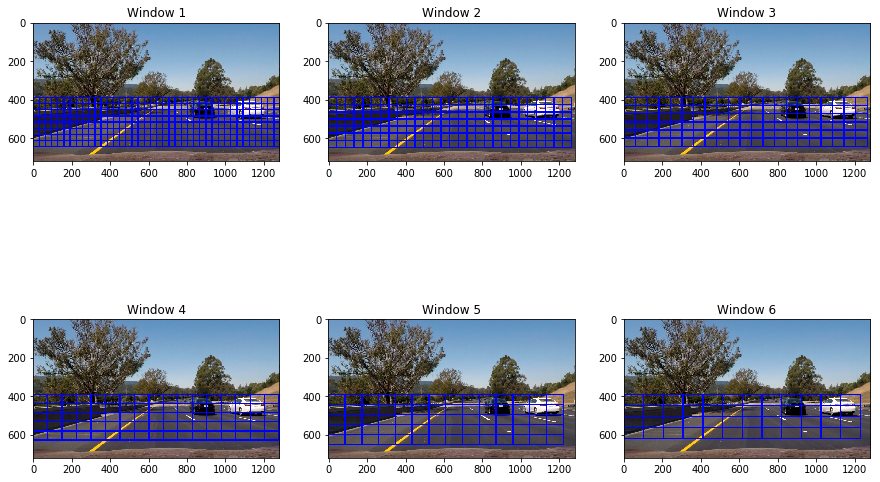

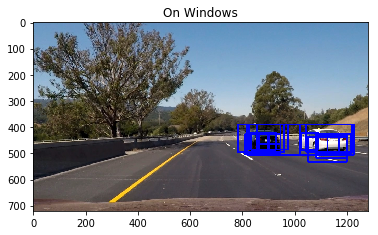

In [8]:
"""
Code reference: Lesson 23 Object Detection: Sliding Window Implementation

"""
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


"""
Code reference: Lesson 23 Object Detection: Search and Classify

"""
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 256), orient=9, 
                   pix_per_cell=8, cell_per_block=2, 
                   hog_channel=0, spatial_feat=True, 
                   hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

    
test_image = cv2.imread('./test_images/test6.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

windows_1 = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[390, 670], 
                         xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windows_2 = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[390, 670], 
                         xy_window=(90,75), xy_overlap=(0.5, 0.5))

windows_3 = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[390, 670], 
                         xy_window=(120, 85), xy_overlap=(0.5, 0.5))

windows_4 = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[390, 670], 
                         xy_window=(150, 95), xy_overlap=(0.5, 0.5))

windows_5 = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[390, 670], 
                         xy_window=(175, 105), xy_overlap=(0.5, 0.5))

windows_6 = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[390, 670], 
                         xy_window=(205, 115), xy_overlap=(0.5, 0.5))

window_img_1 = draw_boxes(test_image, windows_1, color=(0, 0, 255), thick=6)           
window_img_2 = draw_boxes(test_image, windows_2, color=(0, 0, 255), thick=6)       
window_img_3 = draw_boxes(test_image, windows_3, color=(0, 0, 255), thick=6)       
window_img_4 = draw_boxes(test_image, windows_4, color=(0, 0, 255), thick=6)   
window_img_5 = draw_boxes(test_image, windows_5, color=(0, 0, 255), thick=6)   
window_img_6 = draw_boxes(test_image, windows_6, color=(0, 0, 255), thick=6)  

fig = plt.figure(5)
fig.set_size_inches(15, 10)
plt.subplot(231)
plt.imshow(window_img_1)
plt.title('Window 1')
plt.subplot(232)
plt.imshow(window_img_2)
plt.title('Window 2')
plt.subplot(233)
plt.imshow(window_img_3)
plt.title('Window 3')
plt.subplot(234)
plt.imshow(window_img_4)
plt.title('Window 4')
plt.subplot(235)
plt.imshow(window_img_5)
plt.title('Window 5')
plt.subplot(236)
plt.imshow(window_img_6)
plt.title('Window 6')

windows = windows_1 + windows_2 + windows_3 + windows_4 + windows_5 + windows_6

on_windows = search_windows(test_image, windows, svc, X_scaler, color_space='YCrCb', 
                            spatial_size=(32, 32), hist_bins=32, 
                            hist_range=(0, 256), orient=9, 
                            pix_per_cell=8, cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True)

on_windows_boxes = draw_boxes(test_image, on_windows, color=(0, 0, 255), thick=6)  

fig = plt.figure(6)
plt.imshow(on_windows_boxes)
plt.title('On Windows')

### Multiple Detections and False Positives

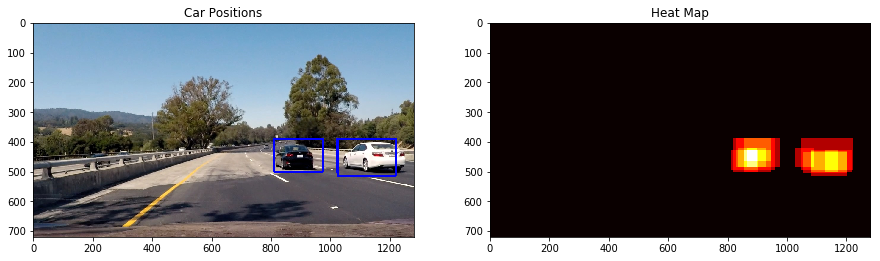

In [9]:
"""
Code reference: Lesson 23 Object Detection: Multiple Detections & False Positives

"""
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

box_list = on_windows

test_image = cv2.imread('./test_images/test4.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
heat = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure(7)
fig.set_size_inches(15, 10)
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')


### Final Pipeline

In [10]:
heat_store = []

def run_pipeline(image):
    
    global heat_store
    
    windows_1 = slide_window(test_image, x_start_stop=[650, None], y_start_stop=[390, 670], 
                         xy_window=(64, 64), xy_overlap=(0.6, 0.6))

    windows_2 = slide_window(test_image, x_start_stop=[650, None], y_start_stop=[390, 670], 
                         xy_window=(90,75), xy_overlap=(0.6, 0.6))

    windows_3 = slide_window(test_image, x_start_stop=[650, None], y_start_stop=[390, 670], 
                         xy_window=(120, 85), xy_overlap=(0.6, 0.6))

    windows_4 = slide_window(test_image, x_start_stop=[650, None], y_start_stop=[390, 670], 
                         xy_window=(150, 95), xy_overlap=(0.6, 0.6))

    windows_5 = slide_window(test_image, x_start_stop=[650, None], y_start_stop=[390, 670], 
                         xy_window=(175, 105), xy_overlap=(0.6, 0.6))

    windows_6 = slide_window(test_image, x_start_stop=[650, None], y_start_stop=[390, 670], 
                         xy_window=(205, 115), xy_overlap=(0.6, 0.6))
    
    windows = windows_1 + windows_2 + windows_3 + windows_4 + windows_5 + windows_6
    
    on_windows = search_windows(image, windows, svc, X_scaler, color_space='YCrCb', 
                                spatial_size=(32, 32), hist_bins=32, 
                                hist_range=(0, 256), orient=9, 
                                pix_per_cell=8, cell_per_block=2, 
                                hog_channel='ALL', spatial_feat=True, 
                                hist_feat=True, hog_feat=True)
    
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, on_windows)
    heat = apply_threshold(heat, 1)
    heat_store.append(heat)
    
    if len(heat_store) > 15:
        for i in range(15):
            heat = heat + heat_store[len(heat_store)-(16-i)] 
            
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image),labels)
    
    return draw_img
    
    

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(run_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████▉| 1260/1261 [1:45:23<00:05,  5.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1h 45min 23s
